# Transfer learning в решении задачи классификации цветов
Датасет классификации цветов (http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) состоит из 102 видов цветов встречаемых в Великобритании. Для каждого класса есть от 40 до 258 примеров, чего мало для обучения с нуля:
<img src="http://bennycheung.github.io/images/deep-transfer-learning-on-small-dataset/flower_train_samples_700.jpg" style="width:50%">

In [1]:
!pip install tensorflow==2.1

In [2]:
!pip install -q efficientnet

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.io
import tarfile
import csv
import sys
import os


import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers
import efficientnet.tfkeras as efn

from sklearn.model_selection import train_test_split

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', keras.__version__)

['flower-dataset-102']
Python       : 3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) 
Numpy        : 1.18.2
Tensorflow   : 2.1.0
Keras        : 2.2.4-tf


In [4]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

Работаем уже с Tensorflow 2.1 но для воспроизводимости сохраним версии всех пакетов

In [5]:
!pip freeze > requirements.txt

# Setup

In [6]:
# В сетап выношу основные настройки, так удобней их перебирать в дальнейшем

EPOCHS               = 5
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.2

CLASS_NUM            = 102
IMG_SIZE             = 250
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/flower-dataset-102/'
PATH = "../working/flower/"

In [7]:
# Setting seed for reproducibility
os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# Data

In [8]:
# прочитаем все названия файлов прям из архива и таргеты к ним
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

df = pd.DataFrame()
df['Id'] = sorted(get_all_filenames(DATA_PATH+"102flowers.tgz"))
df['Category'] = scipy.io.loadmat(DATA_PATH+'imagelabels.mat')['labels'][0] - 1  # классы (0, 1, 2, ...)
df['Category'] = df['Category'].astype(str)

In [9]:
df.head(5)

,Id,Category
0,jpg/image_00001.jpg,76
1,jpg/image_00002.jpg,76
2,jpg/image_00003.jpg,76
3,jpg/image_00004.jpg,76
4,jpg/image_00005.jpg,76


In [10]:
df['Category'].value_counts()

50    258
76    251
45    196
72    194
88    184
     ... 
44     40
26     40
0      40
6      40
20     40
Name: Category, Length: 102, dtype: int64

In [11]:
df['Category'].nunique()

102

In [12]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
opened_tar = tarfile.open(DATA_PATH+"102flowers.tgz")
opened_tar.extractall(PATH)

print(os.listdir(PATH+'jpg')[:5])

Распаковываем картинки
['image_02834.jpg', 'image_04688.jpg', 'image_04580.jpg', 'image_05713.jpg', 'image_03434.jpg']


Пример картинок (random sample)


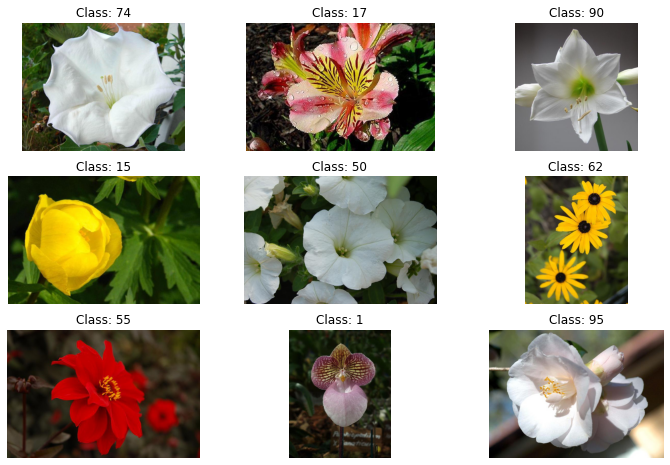

In [13]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+path)
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Пример картинок (random sample)


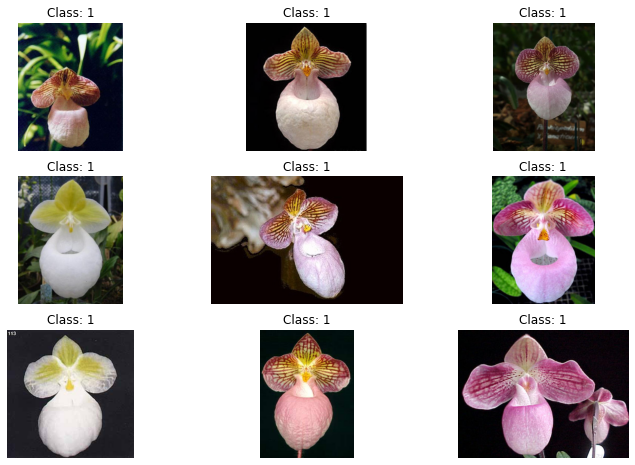

In [14]:
# убедимся что метки классов подгрузились верно
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = df[df['Category']=='1'].sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+path)
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

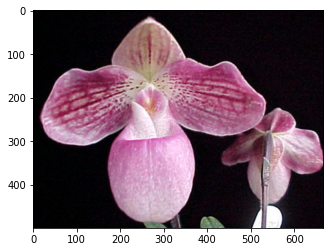

(667, 500)

In [15]:
# как видим изображения имеют разный размер
image = PIL.Image.open(PATH+path)
imgplot = plt.imshow(image)
plt.show()
image.size

 ## Stratify Split

In [16]:
# трейн / тест
train_files, test_files, train_labels, test_labels = \
    train_test_split(df['Id'], df['Category'], test_size=0.2, random_state=42, stratify=df['Category'])

train_files = pd.DataFrame(train_files)
test_files = pd.DataFrame(test_files)
train_files['Category'] = train_labels
test_files['Category'] = test_labels

train_files.shape, test_files.shape

((6551, 2), (1638, 2))

In [17]:
train_files.head(5)

,Id,Category
2361,jpg/image_02362.jpg,42
512,jpg/image_00513.jpg,87
5969,jpg/image_05970.jpg,68
6251,jpg/image_06252.jpg,60
516,jpg/image_00517.jpg,87


In [18]:
train_files['Category'].value_counts()

50    206
76    201
45    157
72    155
88    147
     ... 
20     32
0      32
33     32
6      32
26     32
Name: Category, Length: 102, dtype: int64

In [19]:
test_files['Category'].value_counts()

50    52
76    50
72    39
45    39
88    37
      ..
66     8
15     8
0      8
78     8
25     8
Name: Category, Length: 102, dtype: int64

### Data augmentation

In [20]:
# Аугментация данных очень важна когда у нас не большой датасет (как в нашем случае)

train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                    rotation_range = 50,
                                    shear_range=0.2,
                                    zoom_range=[0.75,1.25],
                                    brightness_range=[0.5, 1.5],
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

### datagen

In [21]:
# "Заворачиваем" наши данные в generator

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, 
    seed=RANDOM_SEED,)

Found 6551 validated image filenames belonging to 102 classes.
Found 1638 validated image filenames belonging to 102 classes.


Пример картинок из train_generator


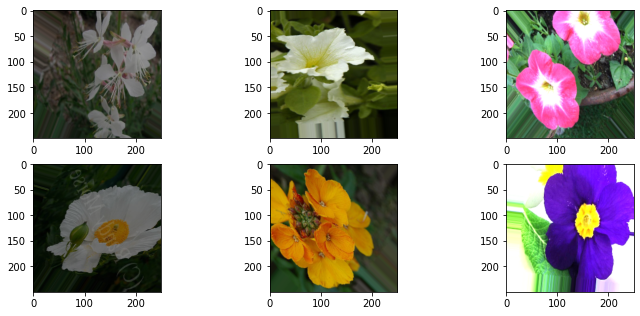

In [22]:
from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

Пример картинок из test_generator


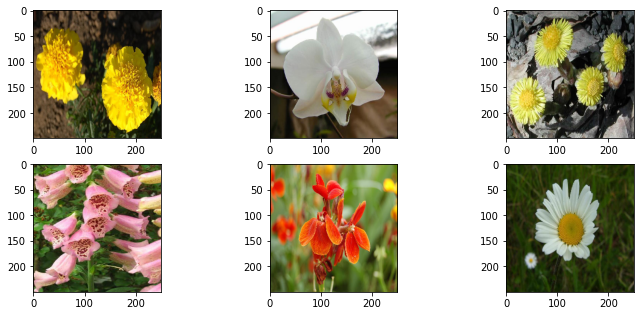

In [23]:
x,y = test_generator.next()
print('Пример картинок из test_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

# Model

In [24]:
input_shape

(250, 250, 3)

In [25]:
base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

165527552/165527152 [==============================] - 12s 0us/step


In [26]:
base_model.summary()

Model: "efficientnet-b6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 125, 125, 56) 1512        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 125, 125, 56) 224         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 125, 125, 56) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [27]:
# first: train only the top layers (which were randomly initialized)
base_model.trainable = False

In [28]:
model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),)
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Model)      (None, 8, 8, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 102)               235110    
Total params: 41,195,246
Trainable params: 235,110
Non-trainable params: 40,960,136
_________________________________________________________________


In [30]:
# сколько слоев
print(len(model.layers))

3


In [31]:
len(model.trainable_variables)

2

In [32]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.training.Model object at 0x7f64a47c4550> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f64a4298d30> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f64a4298da0> True


## Fit

In [33]:
LR=0.001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [34]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [35]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

205/205 [==============================] - 24s 119ms/step - loss: 4.6477 - accuracy: 0.0092
Accuracy: 0.92%


In [36]:
# Обучаем
history = model.fit_generator(
                    train_generator,
                    steps_per_epoch = train_generator.samples//train_generator.batch_size,
                    validation_data = test_generator, 
                    validation_steps = test_generator.samples//test_generator.batch_size,
                    epochs = 5,
                    callbacks = callbacks_list
                    )

Train for 818 steps, validate for 204 steps
Epoch 1/5
817/818 [============================>.] - ETA: 0s - loss: 2.7141 - accuracy: 0.3861
Epoch 00001: saving model to best_model.hdf5
818/818 [==============================] - 188s 230ms/step - loss: 2.7126 - accuracy: 0.3865 - val_loss: 1.4096 - val_accuracy: 0.6471
Epoch 2/5
817/818 [============================>.] - ETA: 0s - loss: 1.5485 - accuracy: 0.6338
Epoch 00002: saving model to best_model.hdf5
818/818 [==============================] - 172s 210ms/step - loss: 1.5482 - accuracy: 0.6340 - val_loss: 0.9169 - val_accuracy: 0.7788
Epoch 3/5
817/818 [============================>.] - ETA: 0s - loss: 1.2208 - accuracy: 0.7002
Epoch 00003: saving model to best_model.hdf5
818/818 [==============================] - 171s 209ms/step - loss: 1.2211 - accuracy: 0.7003 - val_loss: 0.7606 - val_accuracy: 0.8088
Epoch 4/5
817/818 [============================>.] - ETA: 0s - loss: 1.0586 - accuracy: 0.7233
Epoch 00004: saving model to best_mo

In [37]:
# удивительно на сколько эта модель хорошо умеет извлекать признаки!
# даже без дообучения получаем столь высокий Accuracy

In [38]:
model.save('../working/model_step1.hdf5')
model.load_weights('best_model.hdf5')

In [39]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

205/205 [==============================] - 17s 81ms/step - loss: 0.5731 - accuracy: 0.8584
Accuracy: 85.84%


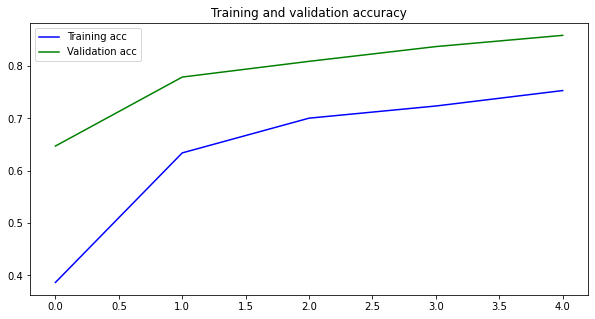

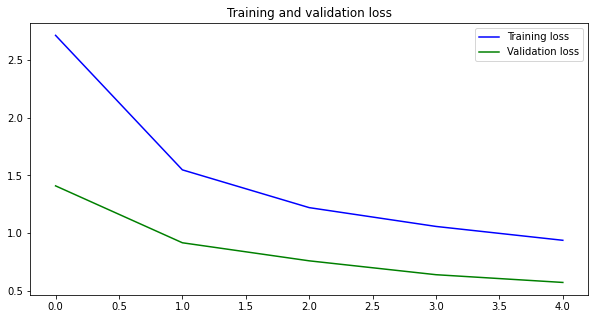

In [40]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

## Step 2

In [41]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  659


In [42]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [43]:
len(base_model.trainable_variables)

291

In [44]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.training.Model object at 0x7f64a47c4550> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f64a4298d30> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f64a4298da0> True


In [45]:
LR=0.0001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Model)      (None, 8, 8, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 102)               235110    
Total params: 41,195,246
Trainable params: 37,931,580
Non-trainable params: 3,263,666
_________________________________________________________________


In [47]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

205/205 [==============================] - 21s 104ms/step - loss: 0.5731 - accuracy: 0.8584
Accuracy: 85.84%


In [48]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = 10,
        callbacks = callbacks_list
)

Train for 818 steps, validate for 204 steps
Epoch 1/10
817/818 [============================>.] - ETA: 0s - loss: 0.9372 - accuracy: 0.7521
Epoch 00001: saving model to best_model.hdf5
818/818 [==============================] - 221s 270ms/step - loss: 0.9366 - accuracy: 0.7523 - val_loss: 0.2918 - val_accuracy: 0.9308
Epoch 2/10
817/818 [============================>.] - ETA: 0s - loss: 0.3318 - accuracy: 0.9064
Epoch 00002: saving model to best_model.hdf5
818/818 [==============================] - 199s 244ms/step - loss: 0.3318 - accuracy: 0.9063 - val_loss: 0.1775 - val_accuracy: 0.9449
Epoch 3/10
817/818 [============================>.] - ETA: 0s - loss: 0.1888 - accuracy: 0.9486
Epoch 00003: saving model to best_model.hdf5
818/818 [==============================] - 200s 244ms/step - loss: 0.1891 - accuracy: 0.9485 - val_loss: 0.1418 - val_accuracy: 0.9596
Epoch 4/10
817/818 [============================>.] - ETA: 0s - loss: 0.1212 - accuracy: 0.9685
Epoch 00004: saving model to bes

In [49]:
model.save('../working/model_step2.hdf5')
model.load_weights('best_model.hdf5')

In [50]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

205/205 [==============================] - 17s 85ms/step - loss: 0.1054 - accuracy: 0.9762
Accuracy: 97.62%


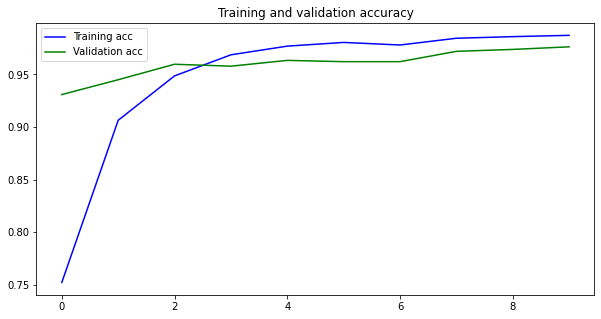

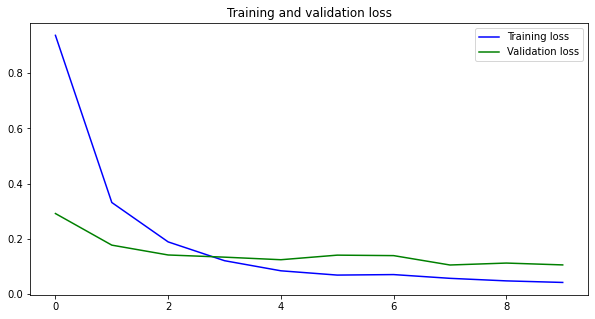

In [51]:
plot_history(history)

## Step 3

In [52]:
base_model.trainable = True

In [53]:
LR=0.00001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [54]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = 10,
        callbacks = callbacks_list
)

Train for 818 steps, validate for 204 steps
Epoch 1/10
817/818 [============================>.] - ETA: 0s - loss: 0.0554 - accuracy: 0.9835
Epoch 00001: saving model to best_model.hdf5
818/818 [==============================] - 325s 398ms/step - loss: 0.0554 - accuracy: 0.9835 - val_loss: 0.1047 - val_accuracy: 0.9761
Epoch 2/10
817/818 [============================>.] - ETA: 0s - loss: 0.0380 - accuracy: 0.9899
Epoch 00002: saving model to best_model.hdf5
818/818 [==============================] - 292s 357ms/step - loss: 0.0380 - accuracy: 0.9899 - val_loss: 0.0963 - val_accuracy: 0.9810
Epoch 3/10
817/818 [============================>.] - ETA: 0s - loss: 0.0233 - accuracy: 0.9936
Epoch 00003: saving model to best_model.hdf5
818/818 [==============================] - 291s 356ms/step - loss: 0.0233 - accuracy: 0.9936 - val_loss: 0.0968 - val_accuracy: 0.9804
Epoch 4/10
817/818 [============================>.] - ETA: 0s - loss: 0.0230 - accuracy: 0.9942
Epoch 00004: saving model to bes

In [55]:
model.save('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [56]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

205/205 [==============================] - 17s 83ms/step - loss: 0.0844 - accuracy: 0.9841
Accuracy: 98.41%


# Step 4

In [57]:
EPOCHS               = 10
BATCH_SIZE           = 4 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-5

IMG_SIZE             = 512
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [58]:
train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                    rotation_range = 90,
                                    #shear_range=0.2,
                                    zoom_range=[0.75,1.25],
                                    #brightness_range=[0.5, 1.5],
                                    #width_shift_range=0.1,
                                    #height_shift_range=0.1,
                                    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [59]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, 
    seed=RANDOM_SEED,)

Found 6551 validated image filenames belonging to 102 classes.
Found 1638 validated image filenames belonging to 102 classes.


In [60]:
base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

In [61]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [62]:
model.load_weights('best_model.hdf5')

In [63]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Train for 1637 steps, validate for 409 steps
Epoch 1/10
1636/1637 [============================>.] - ETA: 0s - loss: 0.3466 - accuracy: 0.9149
Epoch 00001: saving model to best_model.hdf5
1637/1637 [==============================] - 1162s 710ms/step - loss: 0.3465 - accuracy: 0.9149 - val_loss: 0.0675 - val_accuracy: 0.9859
Epoch 2/10
1636/1637 [============================>.] - ETA: 0s - loss: 0.1536 - accuracy: 0.9674
Epoch 00002: saving model to best_model.hdf5
1637/1637 [==============================] - 1124s 686ms/step - loss: 0.1535 - accuracy: 0.9675 - val_loss: 0.0538 - val_accuracy: 0.9890
Epoch 3/10
1636/1637 [============================>.] - ETA: 0s - loss: 0.1089 - accuracy: 0.9775
Epoch 00003: saving model to best_model.hdf5
1637/1637 [==============================] - 1123s 686ms/step - loss: 0.1090 - accuracy: 0.9775 - val_loss: 0.0501 - val_accuracy: 0.9884
Epoch 4/10
1636/1637 [============================>.] - ETA: 0s - loss: 0.0792 - accuracy: 0.9861
Epoch 00004: s

In [64]:
model.save('../working/model_step4.hdf5')
model.load_weights('best_model.hdf5')

In [65]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

410/410 [==============================] - 55s 133ms/step - loss: 0.0436 - accuracy: 0.9927
Accuracy: 99.27%


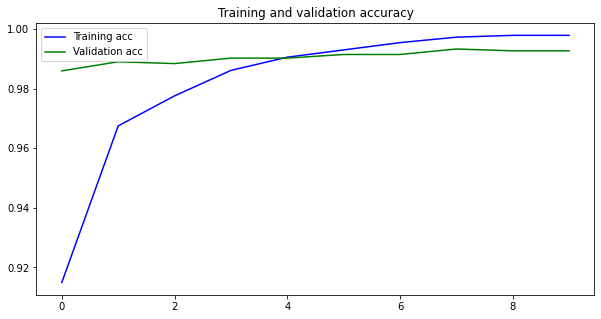

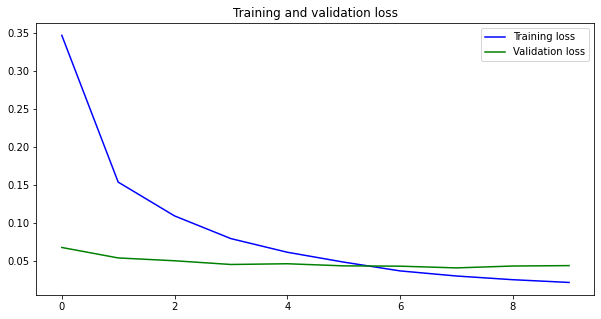

In [66]:
plot_history(history)

# Final Score

In [67]:
from sklearn.metrics import accuracy_score

In [68]:
predictions = model.predict_generator(test_generator, verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

410/410 [==============================] - 56s 136ms/step


In [69]:
filenames_with_dir=test_generator.filenames
submission = pd.DataFrame({'Predict':predictions}, columns=['Predict'], index=filenames_with_dir)
test_files.index = test_files['Id']
tmp_y = pd.concat([submission['Predict'], test_files['Category']], axis=1, sort=False)
tmp_y.head(5)

,Predict,Category
Id,,
jpg/image_05001.jpg,46,46
jpg/image_07204.jpg,6,6
jpg/image_04014.jpg,11,11
jpg/image_07420.jpg,93,93
jpg/image_01122.jpg,45,45


In [70]:
print('Accuracy: %.2f%%' % (accuracy_score(tmp_y['Category'], tmp_y['Predict'],)*100))

Accuracy: 99.27%


# TTA

In [71]:
model.load_weights('best_model.hdf5')

In [72]:
test_datagen = ImageDataGenerator(rescale=1. / 255,
                                 rotation_range = 90,
                                    shear_range=0.2,
                                    zoom_range=[0.75,1.25],
                                    brightness_range=[0.5, 1.5],
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,)

In [73]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, 
    seed=RANDOM_SEED,)

Found 1638 validated image filenames belonging to 102 classes.


Пример картинок из test_generator


IndexError: index 4 is out of bounds for axis 0 with size 4

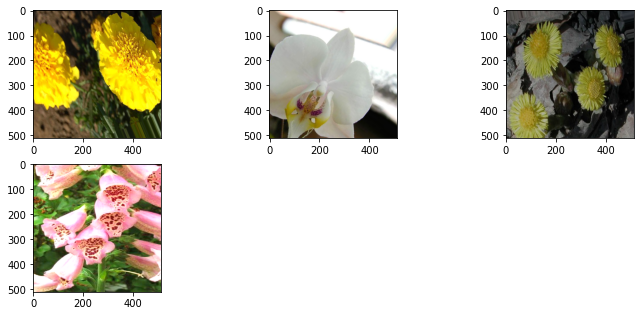

In [74]:
x,y = test_generator.next()
print('Пример картинок из test_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
plt.show()

In [75]:
tta_steps = 10
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_generator, verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

410/410 [==============================] - 134s 326ms/step


In [76]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]
filenames_with_dir=test_generator.filenames
submission = pd.DataFrame({'Predict':predictions}, columns=['Predict'], index=filenames_with_dir)
tmp_y = pd.concat([submission['Predict'], test_files['Category']], axis=1, sort=False)

In [77]:
print('Accuracy: %.2f%%' % (accuracy_score(tmp_y['Category'], tmp_y['Predict'],)*100))

Accuracy: 99.33%


## clean

In [78]:
# Clean PATH
import shutil
shutil.rmtree(PATH)